In [364]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 

In [450]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
df_anyue = pd.read_excel("Individual parameters_START_TKI patients_AYin.xlsx")
df_anyue = df_anyue[["PID","PD_Kg(/day)","PD_Kd(/day)","PD_Km(/day)"]]
df_anyue = df_anyue.rename(columns={"PID": "ID", "PD_Kg(/day)": "kg", "PD_Kd(/day)": "kd", "PD_Km(/day)": "km"})
df_anyue = df_anyue.loc[~df_anyue['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points
cols = df_anyue.columns.tolist()
cols[2],cols[3]=cols[3],cols[2] # swap kd and km so anyue's columns match ours
df_anyue = df_anyue[cols]

In [380]:
# Logistic population model
def system_ode_logistic(time, populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    kd = params[2] #death rate due to medication

    days = time

    dSpop_dt = Spop * (r * (1- (Spop + Rpop)/kmax) - kd)
    dRpop_dt = Rpop * (r * (1- (Spop + Rpop)/kmax))
    return [dSpop_dt, dRpop_dt]

# Cost function
def cost_func_logistic(params, time, data):
    # initial_populations = params[3:]
    initial_populations = [params[3], data[0]-params[3]]
    tspan = [days[0], days[-1]]
    
    pred_data_log = solve_ivp(system_ode_logistic, tspan, initial_populations, 
                             t_eval = np.ravel(days), args = tuple([params[:3]]))
    
    if pred_data_log.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data_log.y[0]
        rpop = pred_data_log.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops - data)**2)
        msq_error = sumsq_error/len(data)
        mean_abs_error = (np.sum(np.abs(sum_pops-data)))/len(data)
        #rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        #rmse = 1e30


    return msq_error


##### logistic with DE

In [414]:
from scipy.optimize import differential_evolution
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    #bounds = [(3e-2, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]) # r, K, kd, spop, rpop
    bounds = [(5e-3, 3e-1), (1.1*max_value, 2*max_value), (1e-2, 1e-1),(0, data[0]-1e-3)] # r, K, kd, spop0, 


    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_logistic, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


In [396]:
df_log = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','kd','spop_0','mse'])
df_log

,r,Kmax,kd,spop_0,mse
A1002,0.023288,27467.748272,0.043502,13865.440830,1.212958e+06
A1004,0.005000,6588.566124,0.028910,5752.092016,1.787391e+03
A1006,0.005000,19917.218330,0.052556,17807.939043,1.432385e+05
A1007,0.005000,13937.123106,0.013629,10536.070048,5.924050e+05
A1008,0.005000,13451.619433,0.017243,11906.325007,5.768976e+05
A1009,0.012299,19869.885271,0.031202,16911.841635,3.969155e+05
A1011,0.005000,7817.361403,0.025644,3908.138118,2.305337e+03
A1012,0.035831,17599.735651,0.022943,15994.665670,2.383147e+06
A1013,0.005000,18969.840025,0.038528,16189.023615,2.770302e+05
A1014,0.005148,542.807192,0.030271,271.274602,2.419035e+02


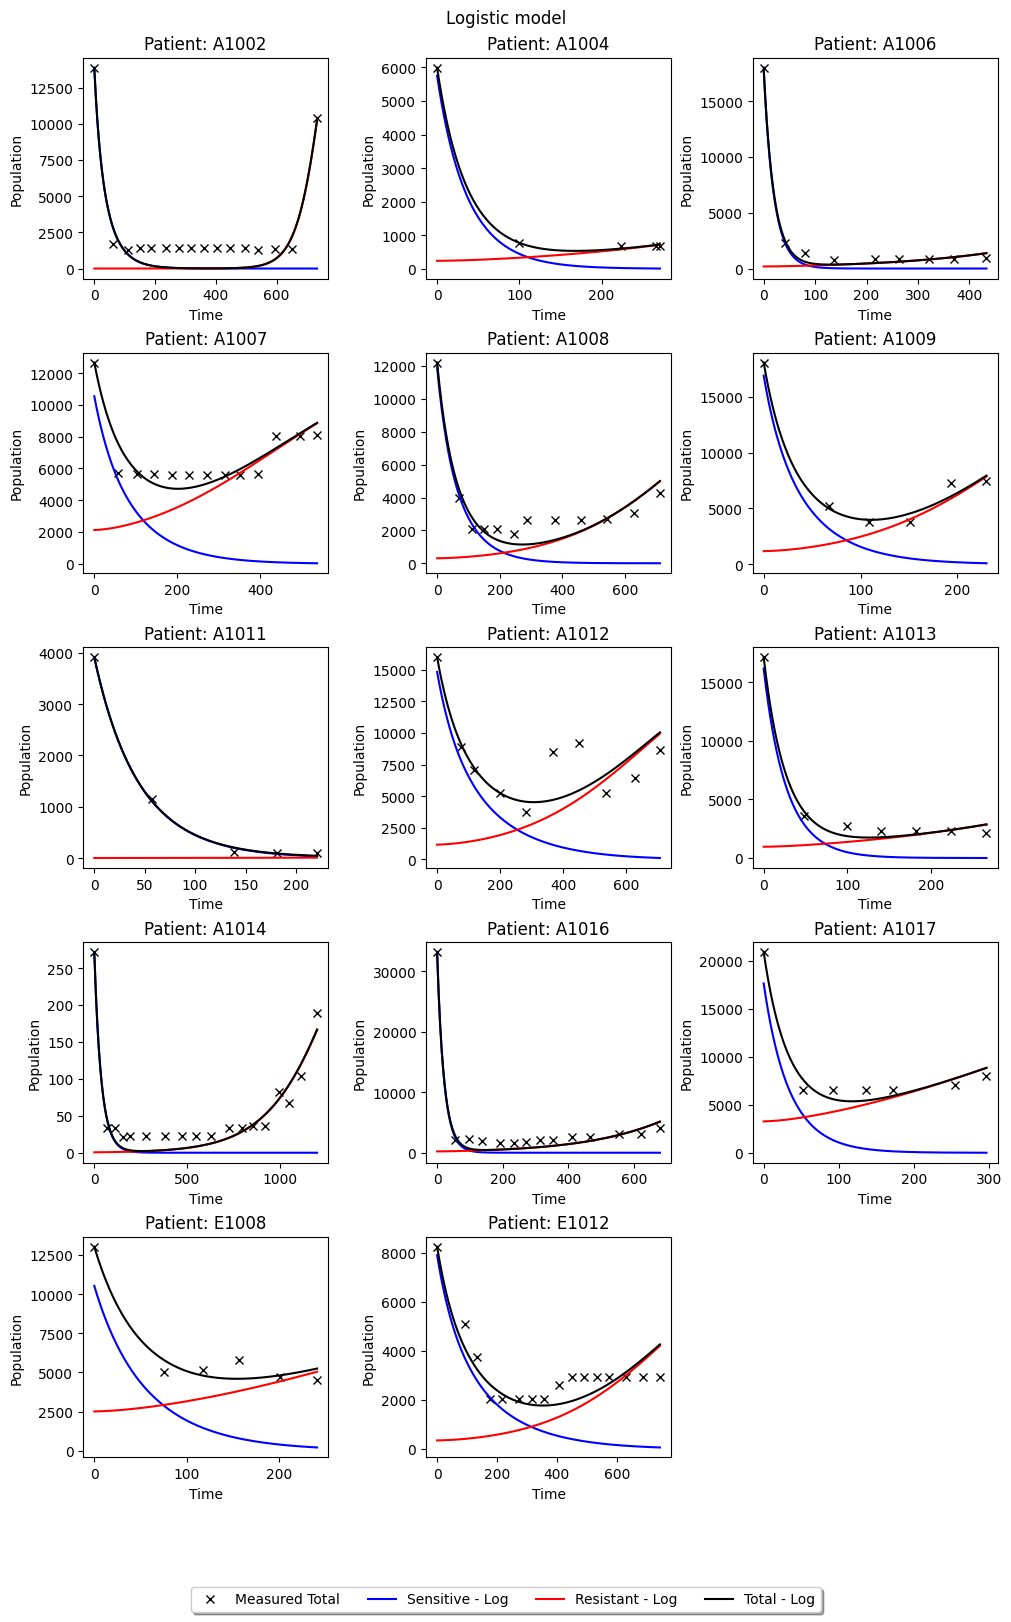

In [415]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Logistic DE MTD vs 1/2 MTD

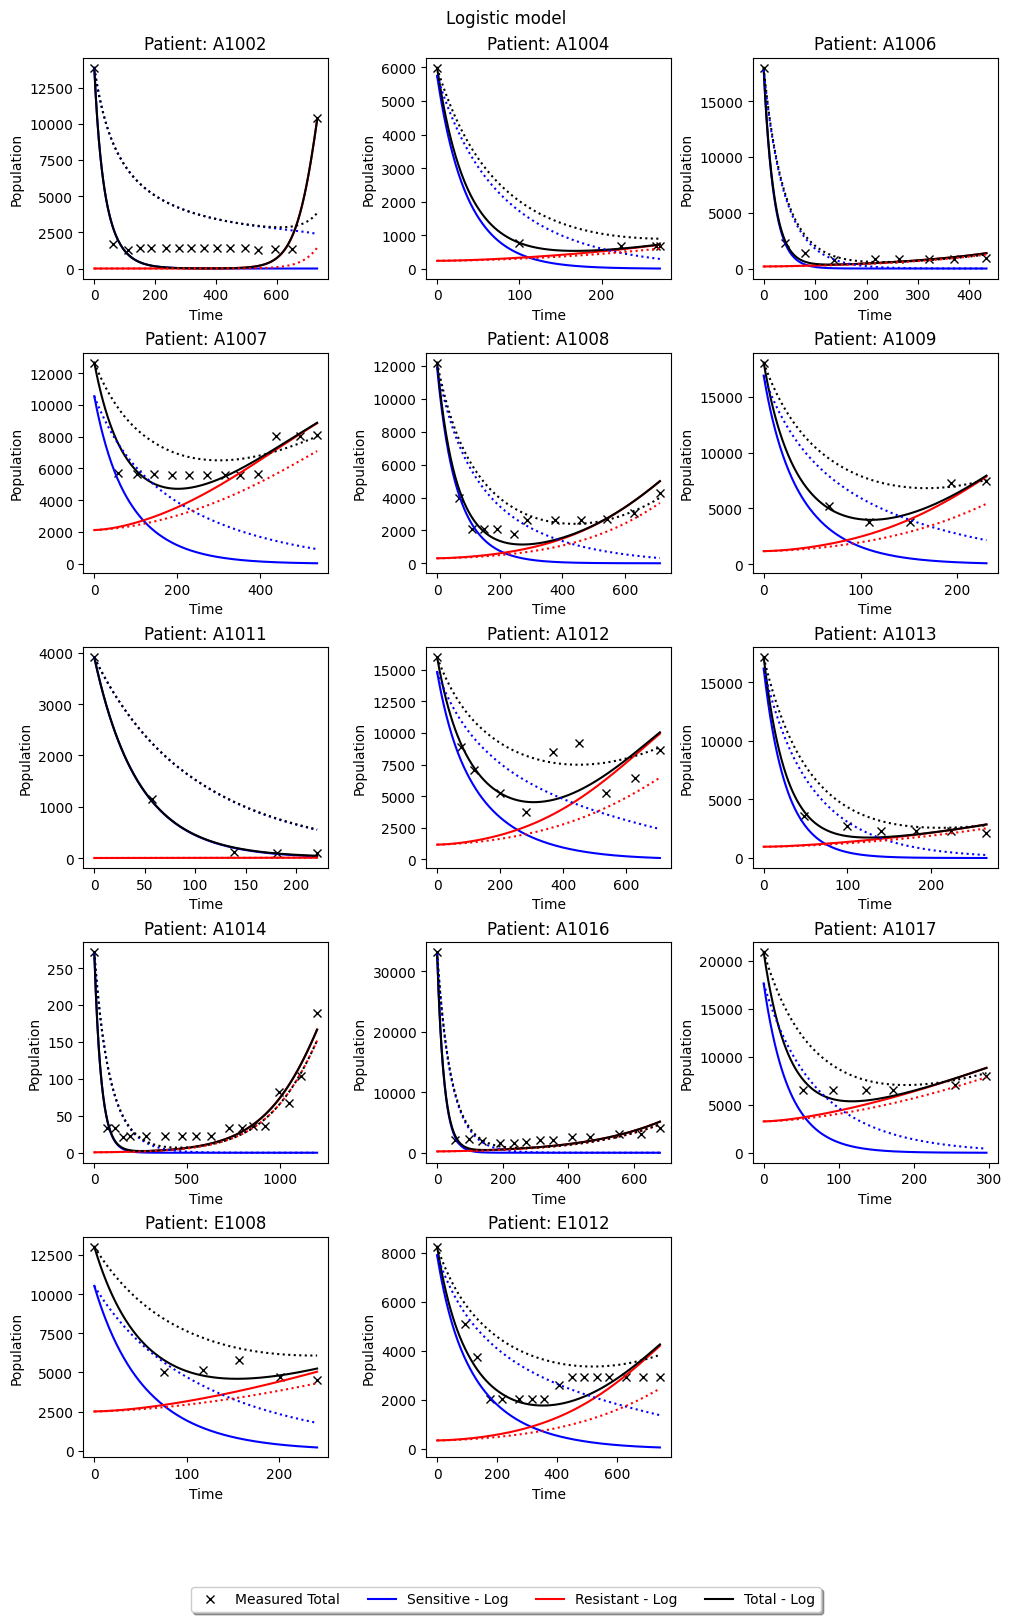

In [416]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3], data[0]-optimal_params_log[3]]

    pred_data_log = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

# half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = [optimal_params_half[3], data[0]-optimal_params_log[3]]

    pred_data_half = solve_ivp(system_ode_logistic, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)



#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')

     # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Log'),
                   Line2D([0], [0], color='r', label='Resistant - Log'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Log'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model')  
plt.show()

##### Extending time MTD vs 1/2 MTD logistic

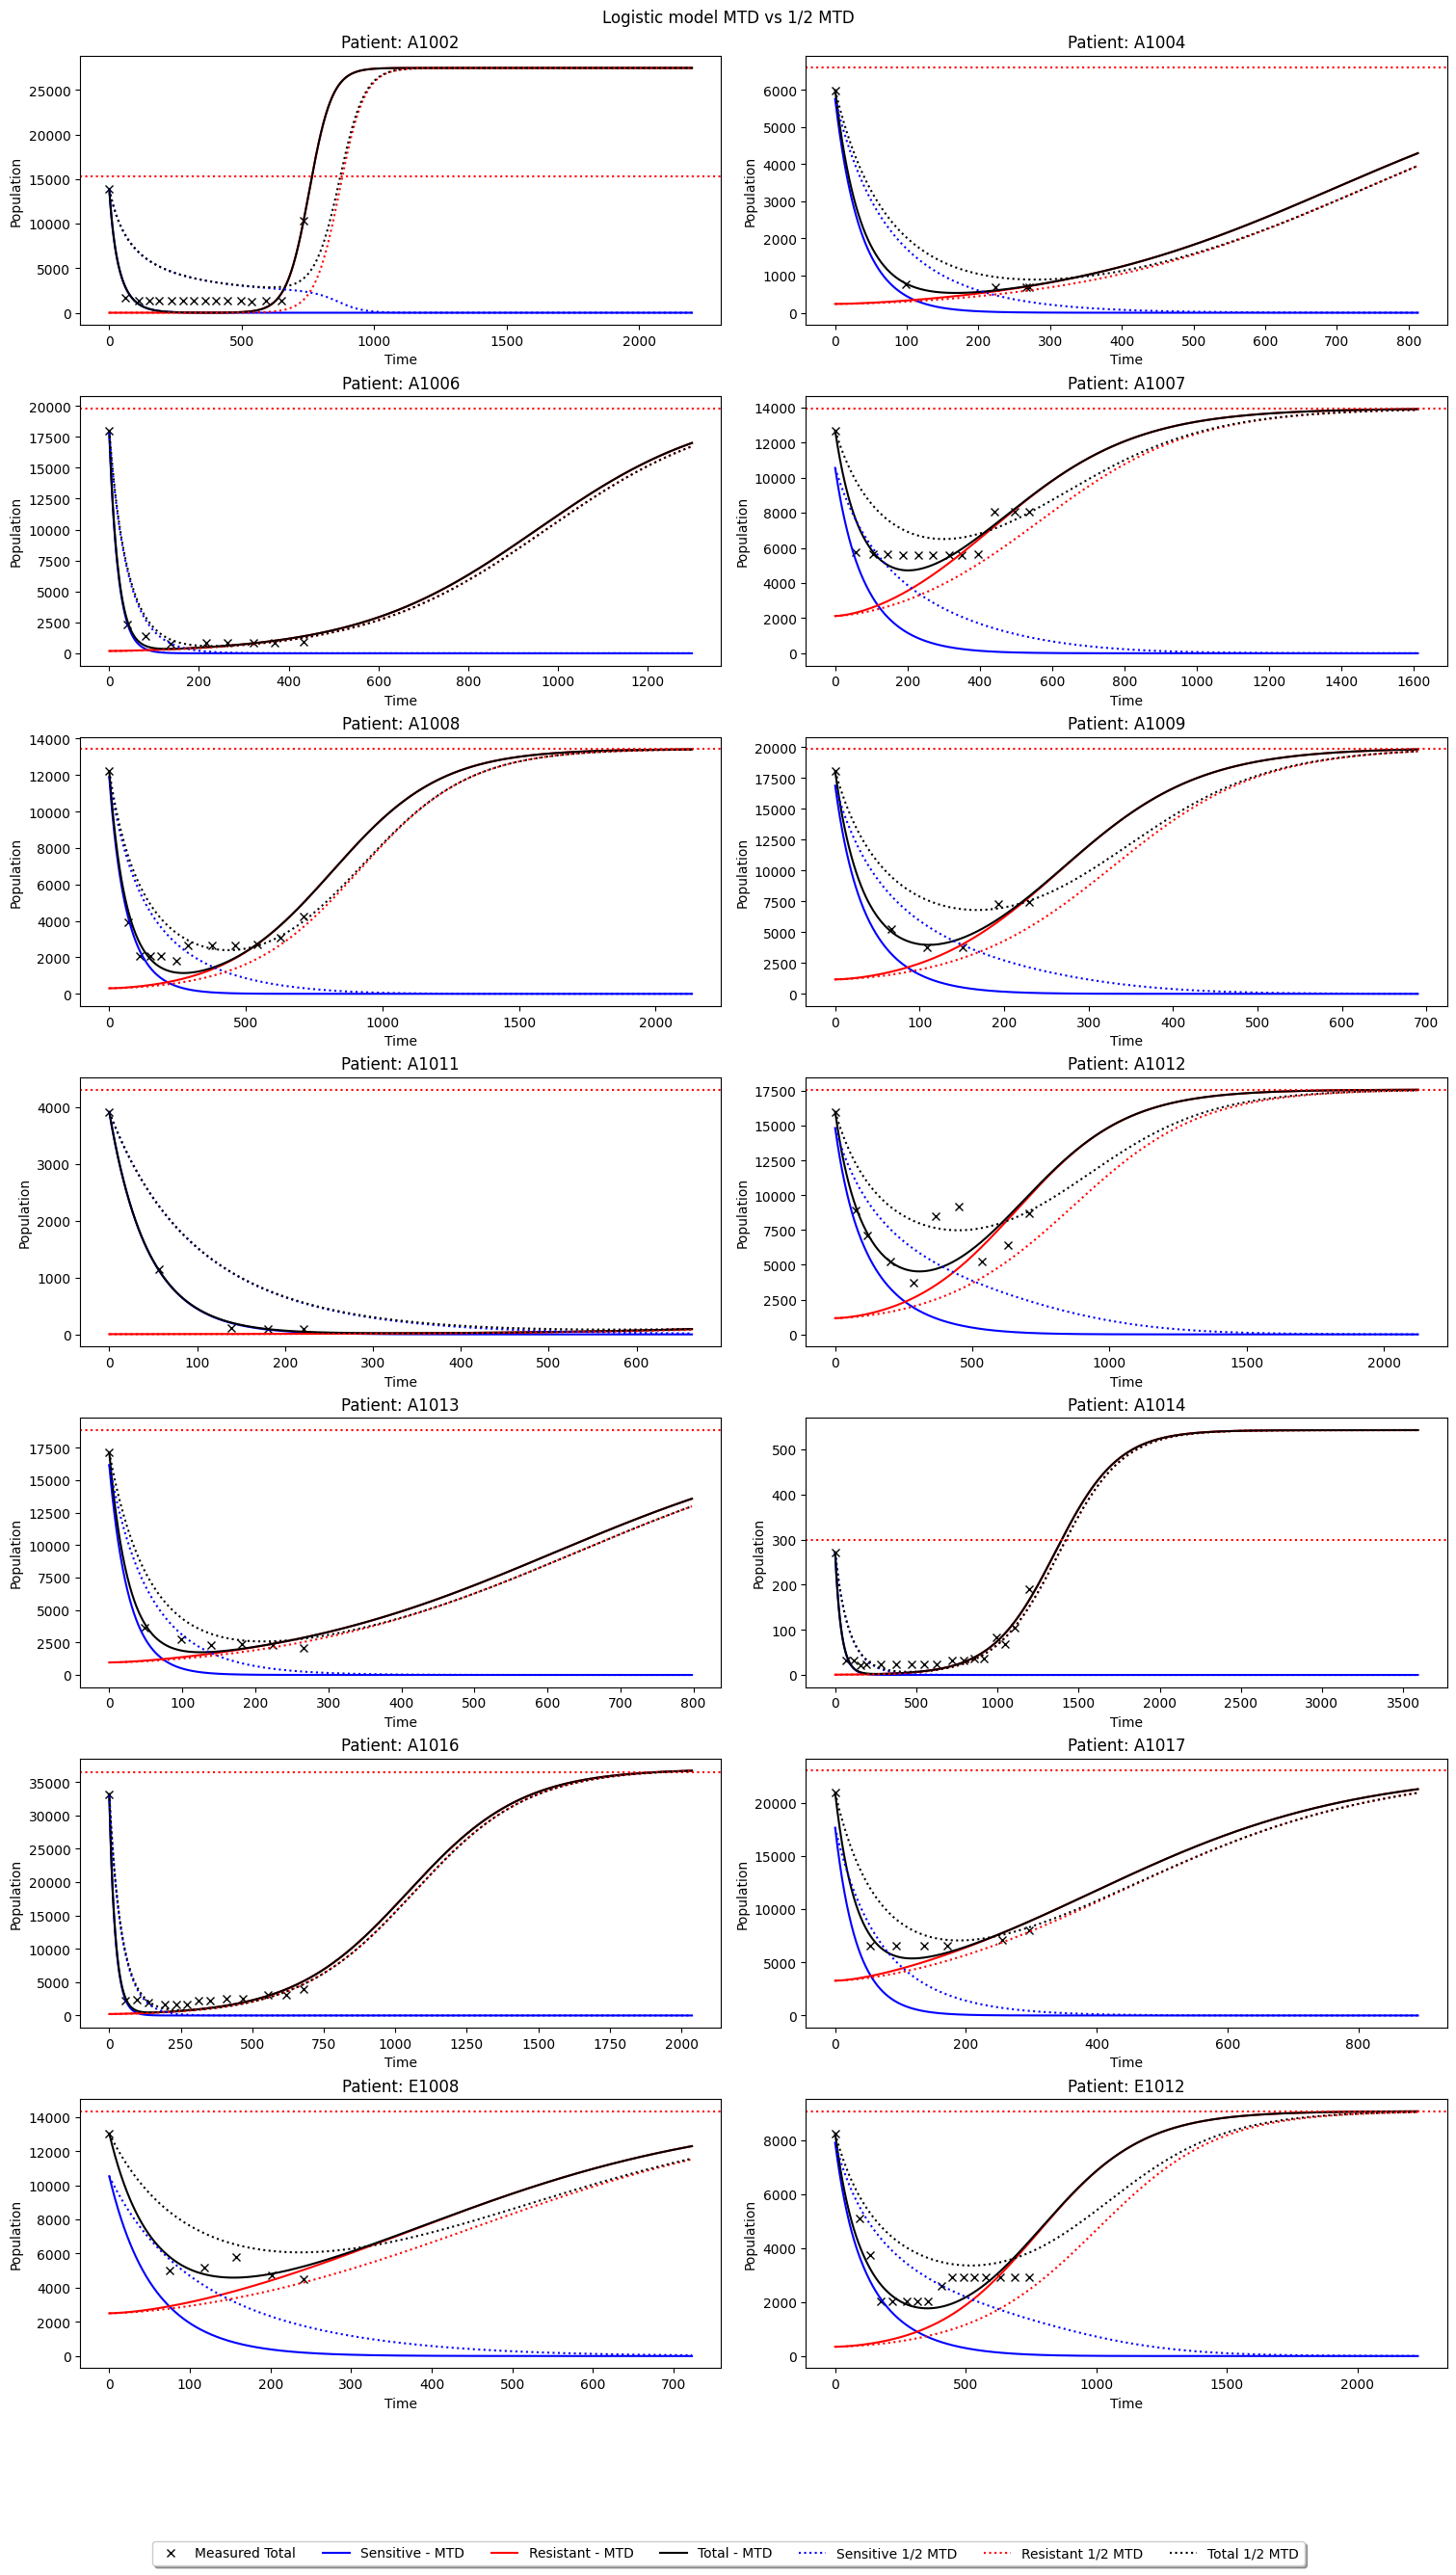

In [453]:
# Make a deep copy of master_dictionary to change medication parameters in

master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 25), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    sim_time_factor = 3

    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

    ### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)




### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

    # Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]

    # Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]

    # Append the id and x_value_progression to the list
    progression_list.append((id, x_value_progression))
    progression_half_list.append((id, x_value_progression_half))


#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data_log.sol(tspan)[0], 'b-', label='Sensitive - Log') # plot logistic model
    ax.plot(tspan, pred_data_log.sol(tspan)[1], 'r-', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log, 'k-', label='Total - Log')
    ax.axhline(y=1.1*data[0], color='r', linestyle=':') ### line to show progression


    # plot with half medication
    ax.plot(tspan, pred_data_log_half.sol(tspan)[0], 'b:', label='Sensitive - Log') 
    ax.plot(tspan, pred_data_log_half.sol(tspan)[1], 'r:', label='Resistant - Log') 
    ax.plot(tspan, sum_pops_log_half, 'k:', label='Total - Log')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - MTD'),
                   Line2D([0], [0], color='r', label='Resistant - MTD'),
                   Line2D([0], [0], color='k',label='Total - MTD'),
                   Line2D([0], [0], color='b', linestyle=':', label='Sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle=':', label='Resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Logistic model MTD vs 1/2 MTD')  
plt.show()

##### TTP

In [452]:
progression_list = []
progression_half_list = []

master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    sim_time_factor = 20
    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params original medication 
    optimal_params_log = master_dictionary[id]
    init_populations_log = [optimal_params_log[3],data[0]-optimal_params_log[3]]
    pred_data_log = solve_ivp(system_ode_logistic, [0,sim_time_factor*days[-1]],
                            init_populations_log, dense_output=True,
                            args = tuple([optimal_params_log[:3]]))
    sum_pops_log = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params 1/2 medication
    optimal_params_log_half = master_dictionary_copy[id] 
    init_populations_log_half = [optimal_params_log_half[3],data[0]-optimal_params_log_half[3]]

    pred_data_log_half = solve_ivp(system_ode_logistic, [0, sim_time_factor*days[-1]],
                            init_populations_log_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_log_half[:3]]))
    sum_pops_log_half = np.sum(pred_data_log_half.sol(tspan), axis=0)

# Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops_log - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]
    progression_list.append((id, x_value_progression))

# Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_log_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]
    progression_half_list.append((id, x_value_progression_half))

df_progression = pd.DataFrame(progression_list, columns=['id', 'x_value_progression'])
df_progression_half = pd.DataFrame(progression_half_list, columns=['id', 'x_value_progression_half'])
df_all_progressions = pd.merge(df_progression, df_progression_half, on='id')
df_all_progressions.set_index('id', inplace=True)
print(df_all_progressions)

       x_value_progression  x_value_progression_half
id                                                  
A1002           763.083083                865.805806
A1004          1573.373373               1616.776777
A1006          1829.089089               1846.426426
A1007          2171.651652               2332.912913
A1008          2846.846847               2946.486486
A1009           709.109109                782.782783
A1011          1588.368368               1619.339339
A1012         14018.258258               7512.312312
A1013          1981.021021               2007.647648
A1014          1389.909910               1413.873874
A1016          1930.290290               1957.477477
A1017          1878.918919               1920.540541
E1008          1929.929930               2007.127127
E1012          2442.762763               2815.135135
